In [1]:
# configures the Jupyter Notebook for high-resolution inline plots,
# suppresses future warnings, and sets up Seaborn for creating plots with a dark grid,
# custom color palette (Set1), and a figure size of 12x8 inches.

%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

sns.set_theme(context="talk", style="darkgrid", 
              palette="Set1", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Modeling Volatility with GARCH class models

## Modeling stock returns' volatility with ARCH models

In [2]:
# 1. import the necessary libraries: Pandas for data manipulation,
# yfinance for fetching financial data, and arch_model for ARCH/GARCH modeling.
import pandas as pd
import yfinance as yf
from arch import arch_model

In [3]:
# 2. Specify the risky asset and the time horizon:
RISKY_ASSET = "META"
START_DATE = "2017-01-01"
END_DATE = "2023-09-15"

In [4]:
# 3. Download data from Yahoo Finance:
df = yf.download(RISKY_ASSET,
                 start=START_DATE,
                 end=END_DATE)

print(f"Downloaded {df.shape[0]} rows of data.")

[*********************100%%**********************]  1 of 1 completed
Downloaded 1686 rows of data.


Average return: 0.09%


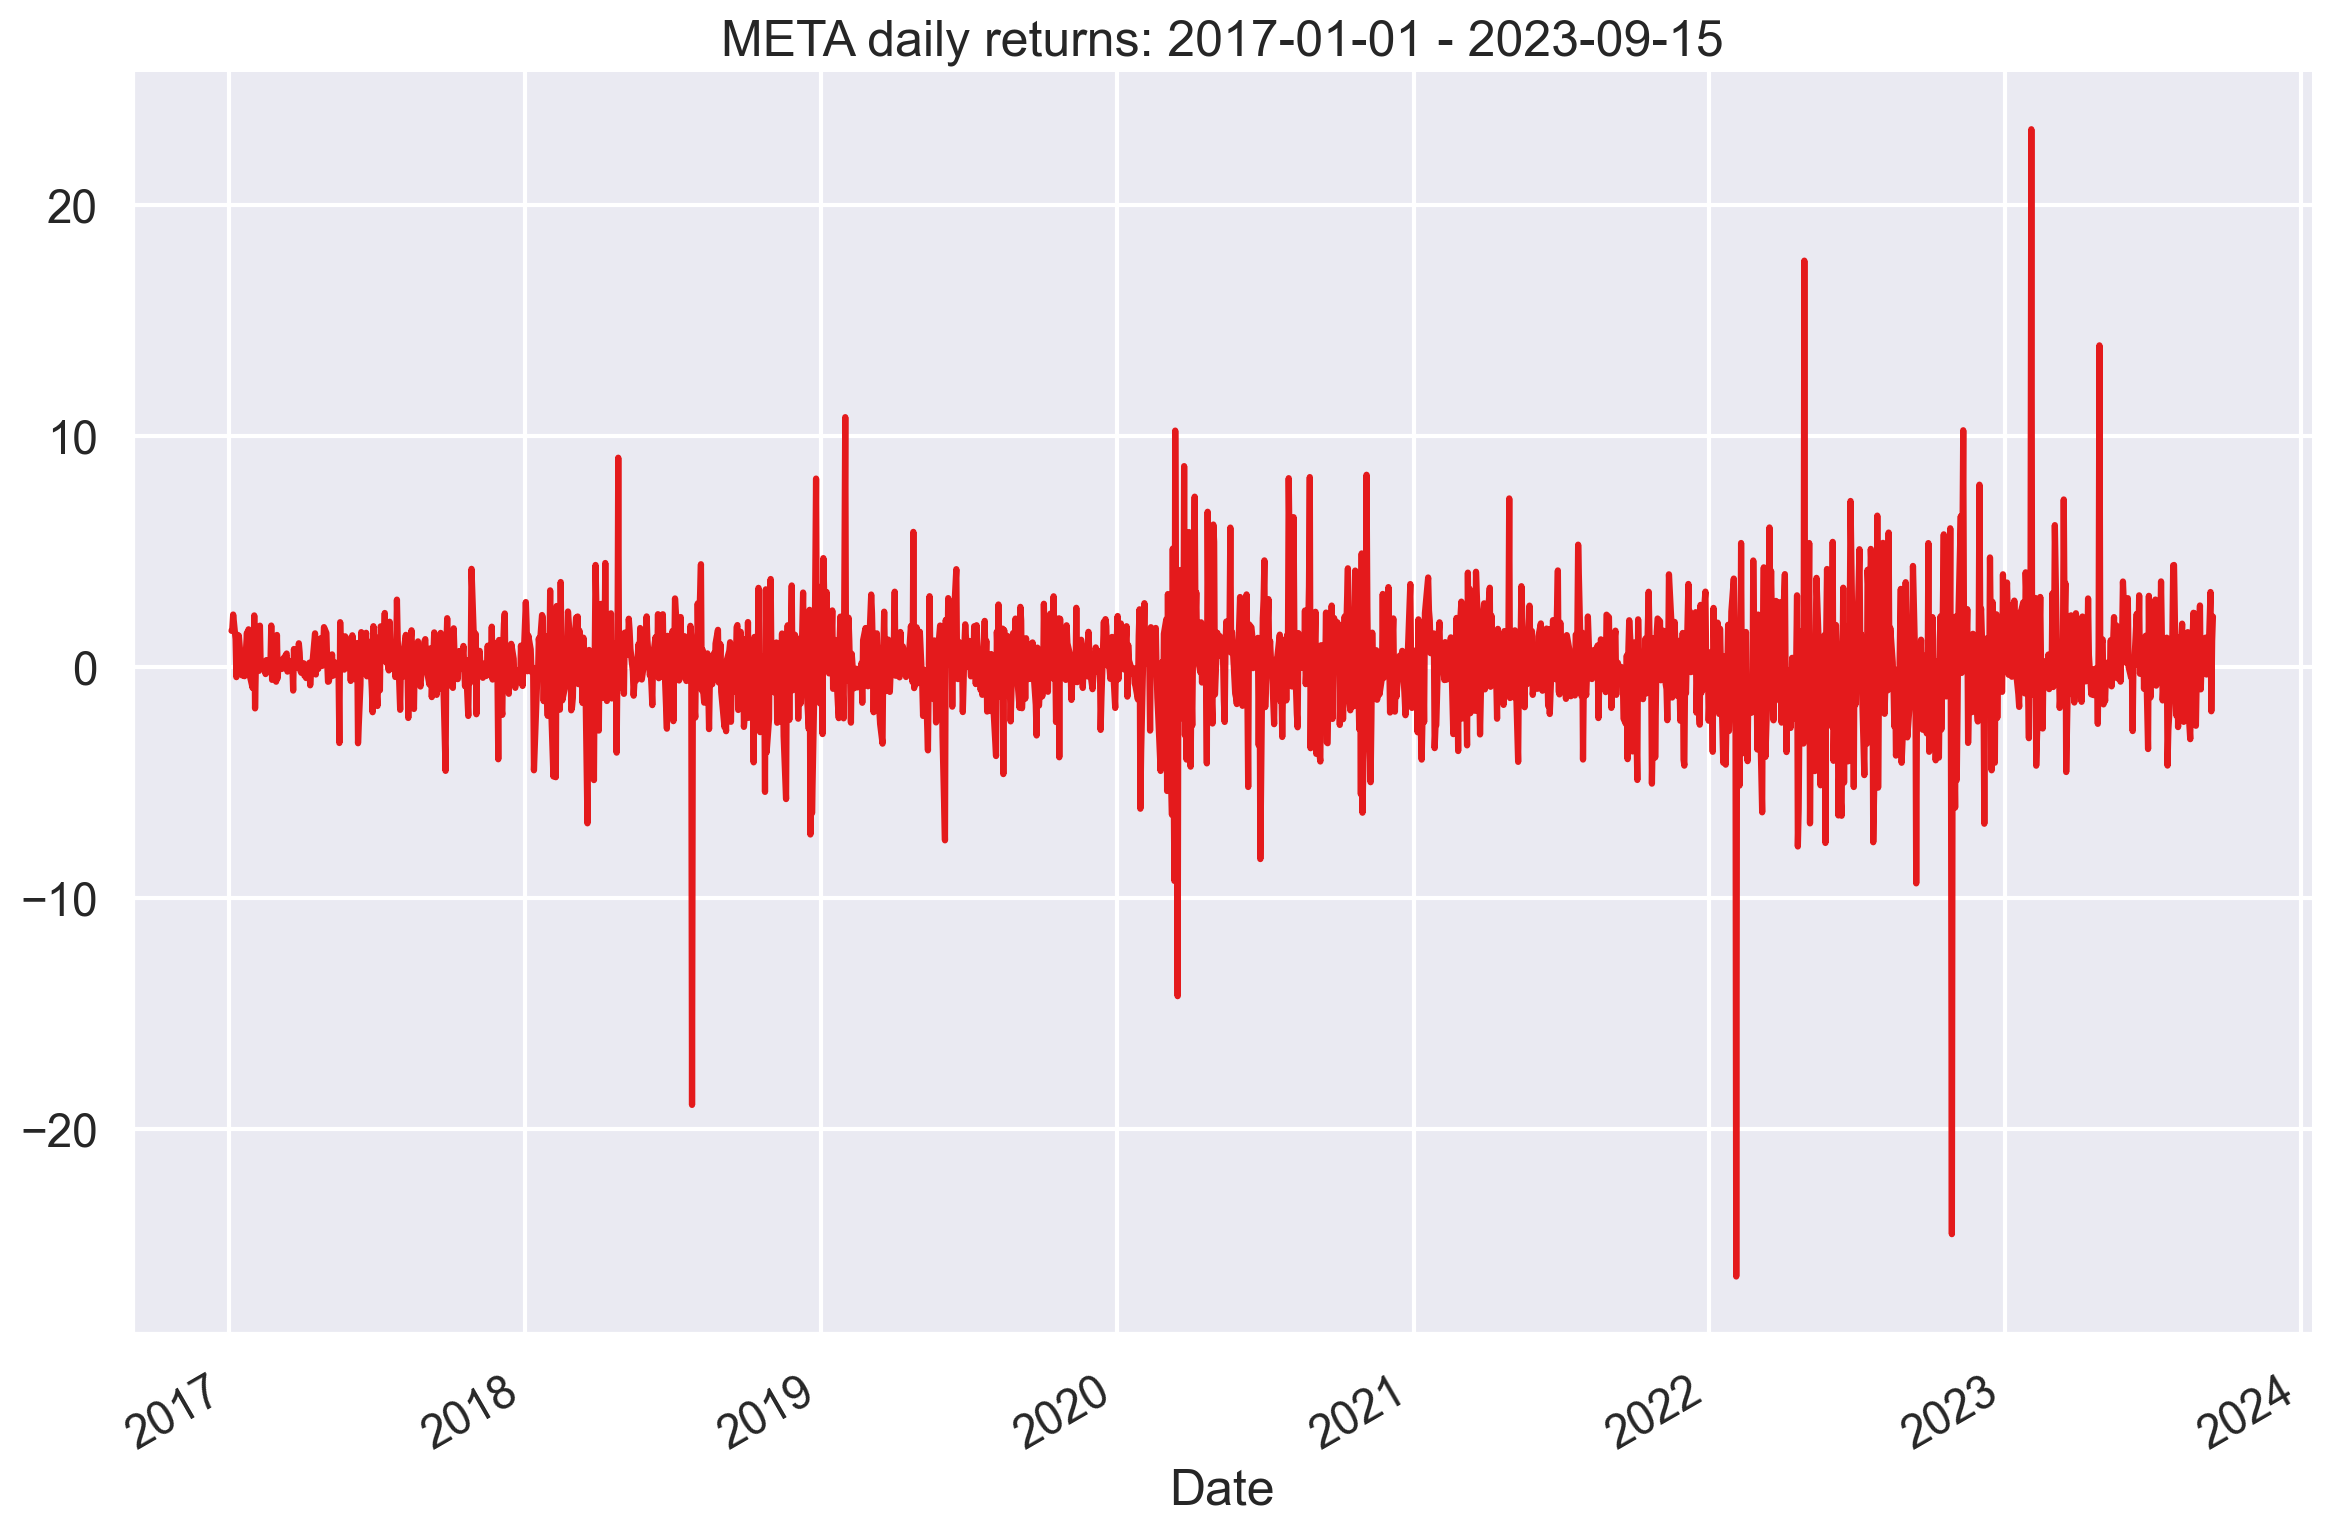

In [5]:
# 4. Calculate daily returns:
returns = 100 * df["Adj Close"].pct_change().dropna()
returns.name = "asset_returns"
print(f"Average return: {round(returns.mean(), 2)}%")
returns.plot(title=f"{RISKY_ASSET} daily returns: {START_DATE} - {END_DATE}");

sns.despine()
plt.tight_layout()

In [6]:
# 5. Specify the ARCH model:
model = arch_model(returns, mean="Zero", vol="ARCH", p=1, q=0)

In [7]:
# 6. Estimate the model and print the summary:
fitted_model = model.fit(disp="off")
print(fitted_model.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -3922.81
Distribution:                  Normal   AIC:                           7849.63
Method:            Maximum Likelihood   BIC:                           7860.49
                                        No. Observations:                 1685
Date:                Fri, Sep 15 2023   Df Residuals:                     1685
Time:                        20:38:01   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          4.7947      0.681      7.039  1.932e-12   [  3.46

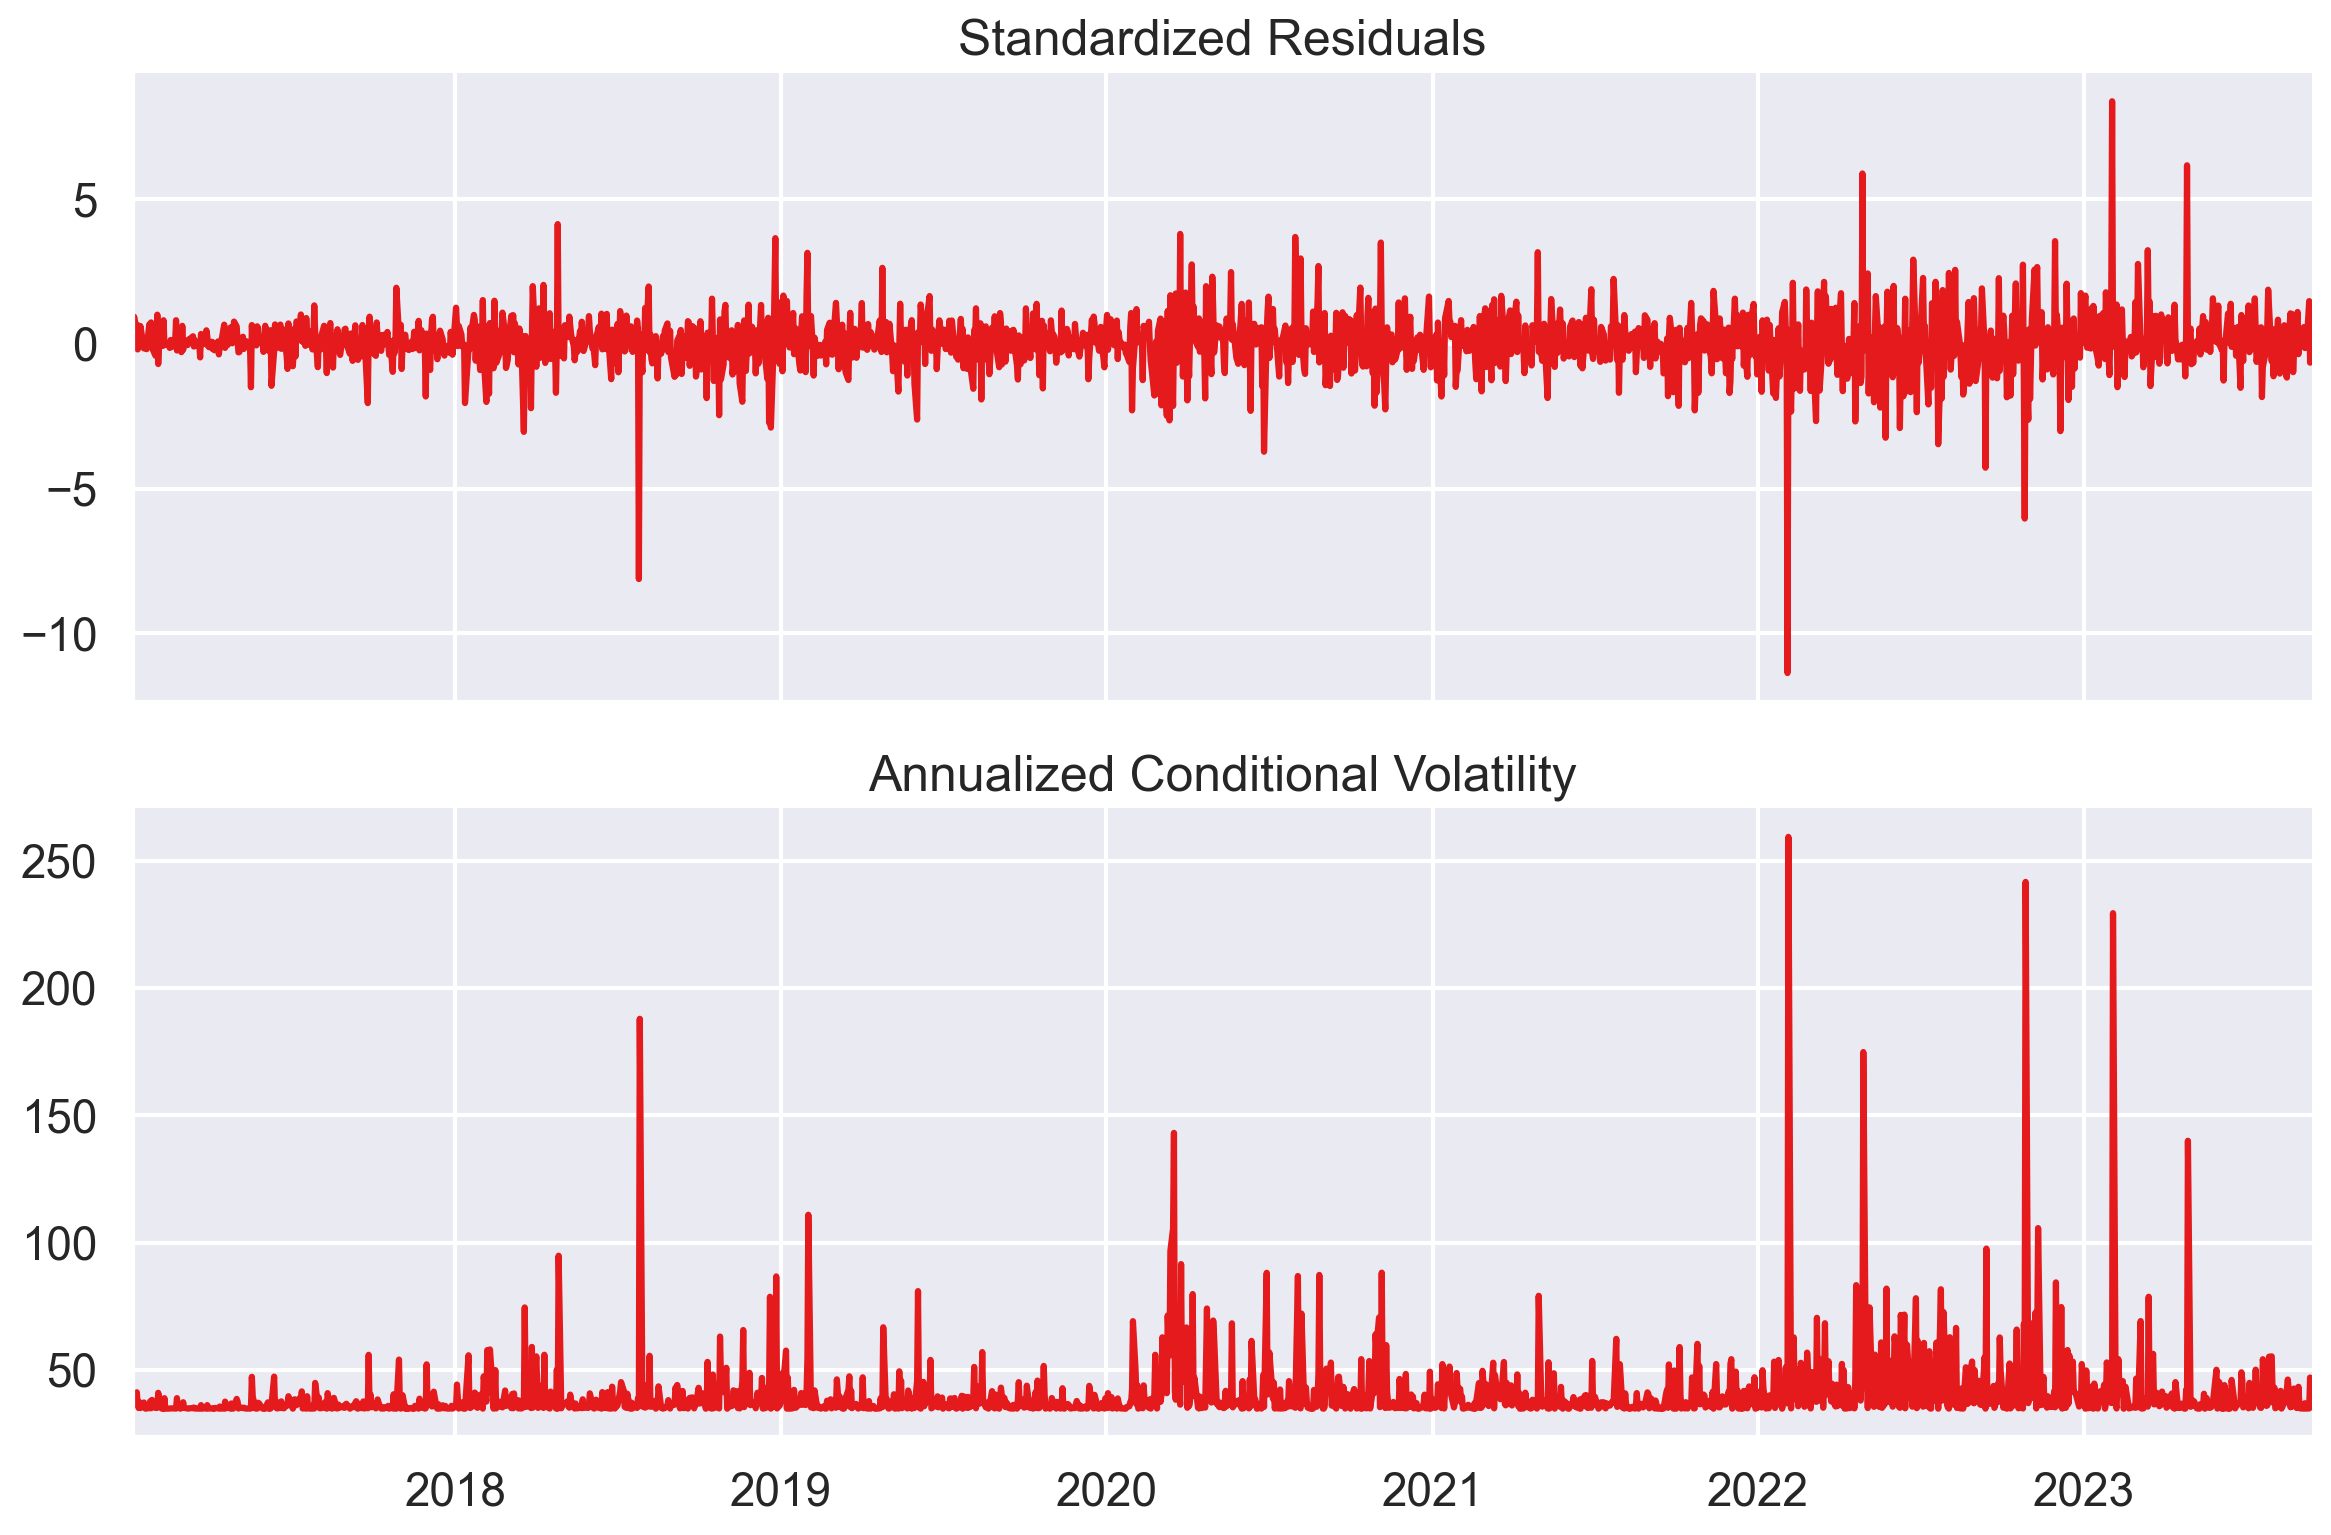

In [8]:
# 7. Plot the residuals and the conditional volatility:
fitted_model.plot(annualize="D")

sns.despine()
plt.tight_layout()

In [9]:
# In the cell below we confirm that the standardized residuals are simply residuals divided by the conditional volatility.
diagnostics_dict = {
    "resids": fitted_model.resid,
    "conditional_volatility": fitted_model.conditional_volatility,
    "std_resid": fitted_model.std_resid,
    "std_resid_manual": fitted_model.resid / fitted_model.conditional_volatility,
}

df_diagnostics = pd.DataFrame(data = diagnostics_dict)
df_diagnostics

,resids,conditional_volatility,std_resid,std_resid_manual
Date,,,,
2017-01-04,1.565978,2.298635,0.681264,0.681264
2017-01-05,1.668208,2.391099,0.697674,0.697674
2017-01-06,2.270660,2.416970,0.939466,0.939466
2017-01-09,1.207356,2.595096,0.465245,0.465245
2017-01-10,-0.440355,2.311529,-0.190504,-0.190504
...,...,...,...,...
2023-09-08,-0.261157,2.192087,-0.119136,-0.119136
2023-09-11,3.246159,2.195540,1.478524,1.478524
2023-09-12,-1.918323,2.959601,-0.648169,-0.648169


In [10]:
# Test the residuals of the ARCH(1) model with the LM test.
from statsmodels.stats.diagnostic import het_arch
het_arch(fitted_model.resid)

(15.374365699717071,
 0.11899753520978472,
 1.5414888752977904,
 0.1187843098522678)

In [11]:
# As the residuals come from a model in which we estimated two parameters (omega and alpha), we should correct for that when using the `het_arch` test.
het_arch(fitted_model.resid, ddof=2)

(15.35600824813532,
 0.11961143128651526,
 1.5414888752977904,
 0.1187843098522678)

## Modeling stock returns' volatility with GARCH models

In [12]:
# 1. Specify the GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

In [13]:
# 2. Estimate the model and print the summary:
fitted_model = model.fit(disp="off")
print(fitted_model.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3844.08
Distribution:                  Normal   AIC:                           7694.15
Method:            Maximum Likelihood   BIC:                           7710.44
                                        No. Observations:                 1685
Date:                Fri, Sep 15 2023   Df Residuals:                     1685
Time:                        20:38:18   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.6448      0.391      1.650  9.897e-02   [ -0.12

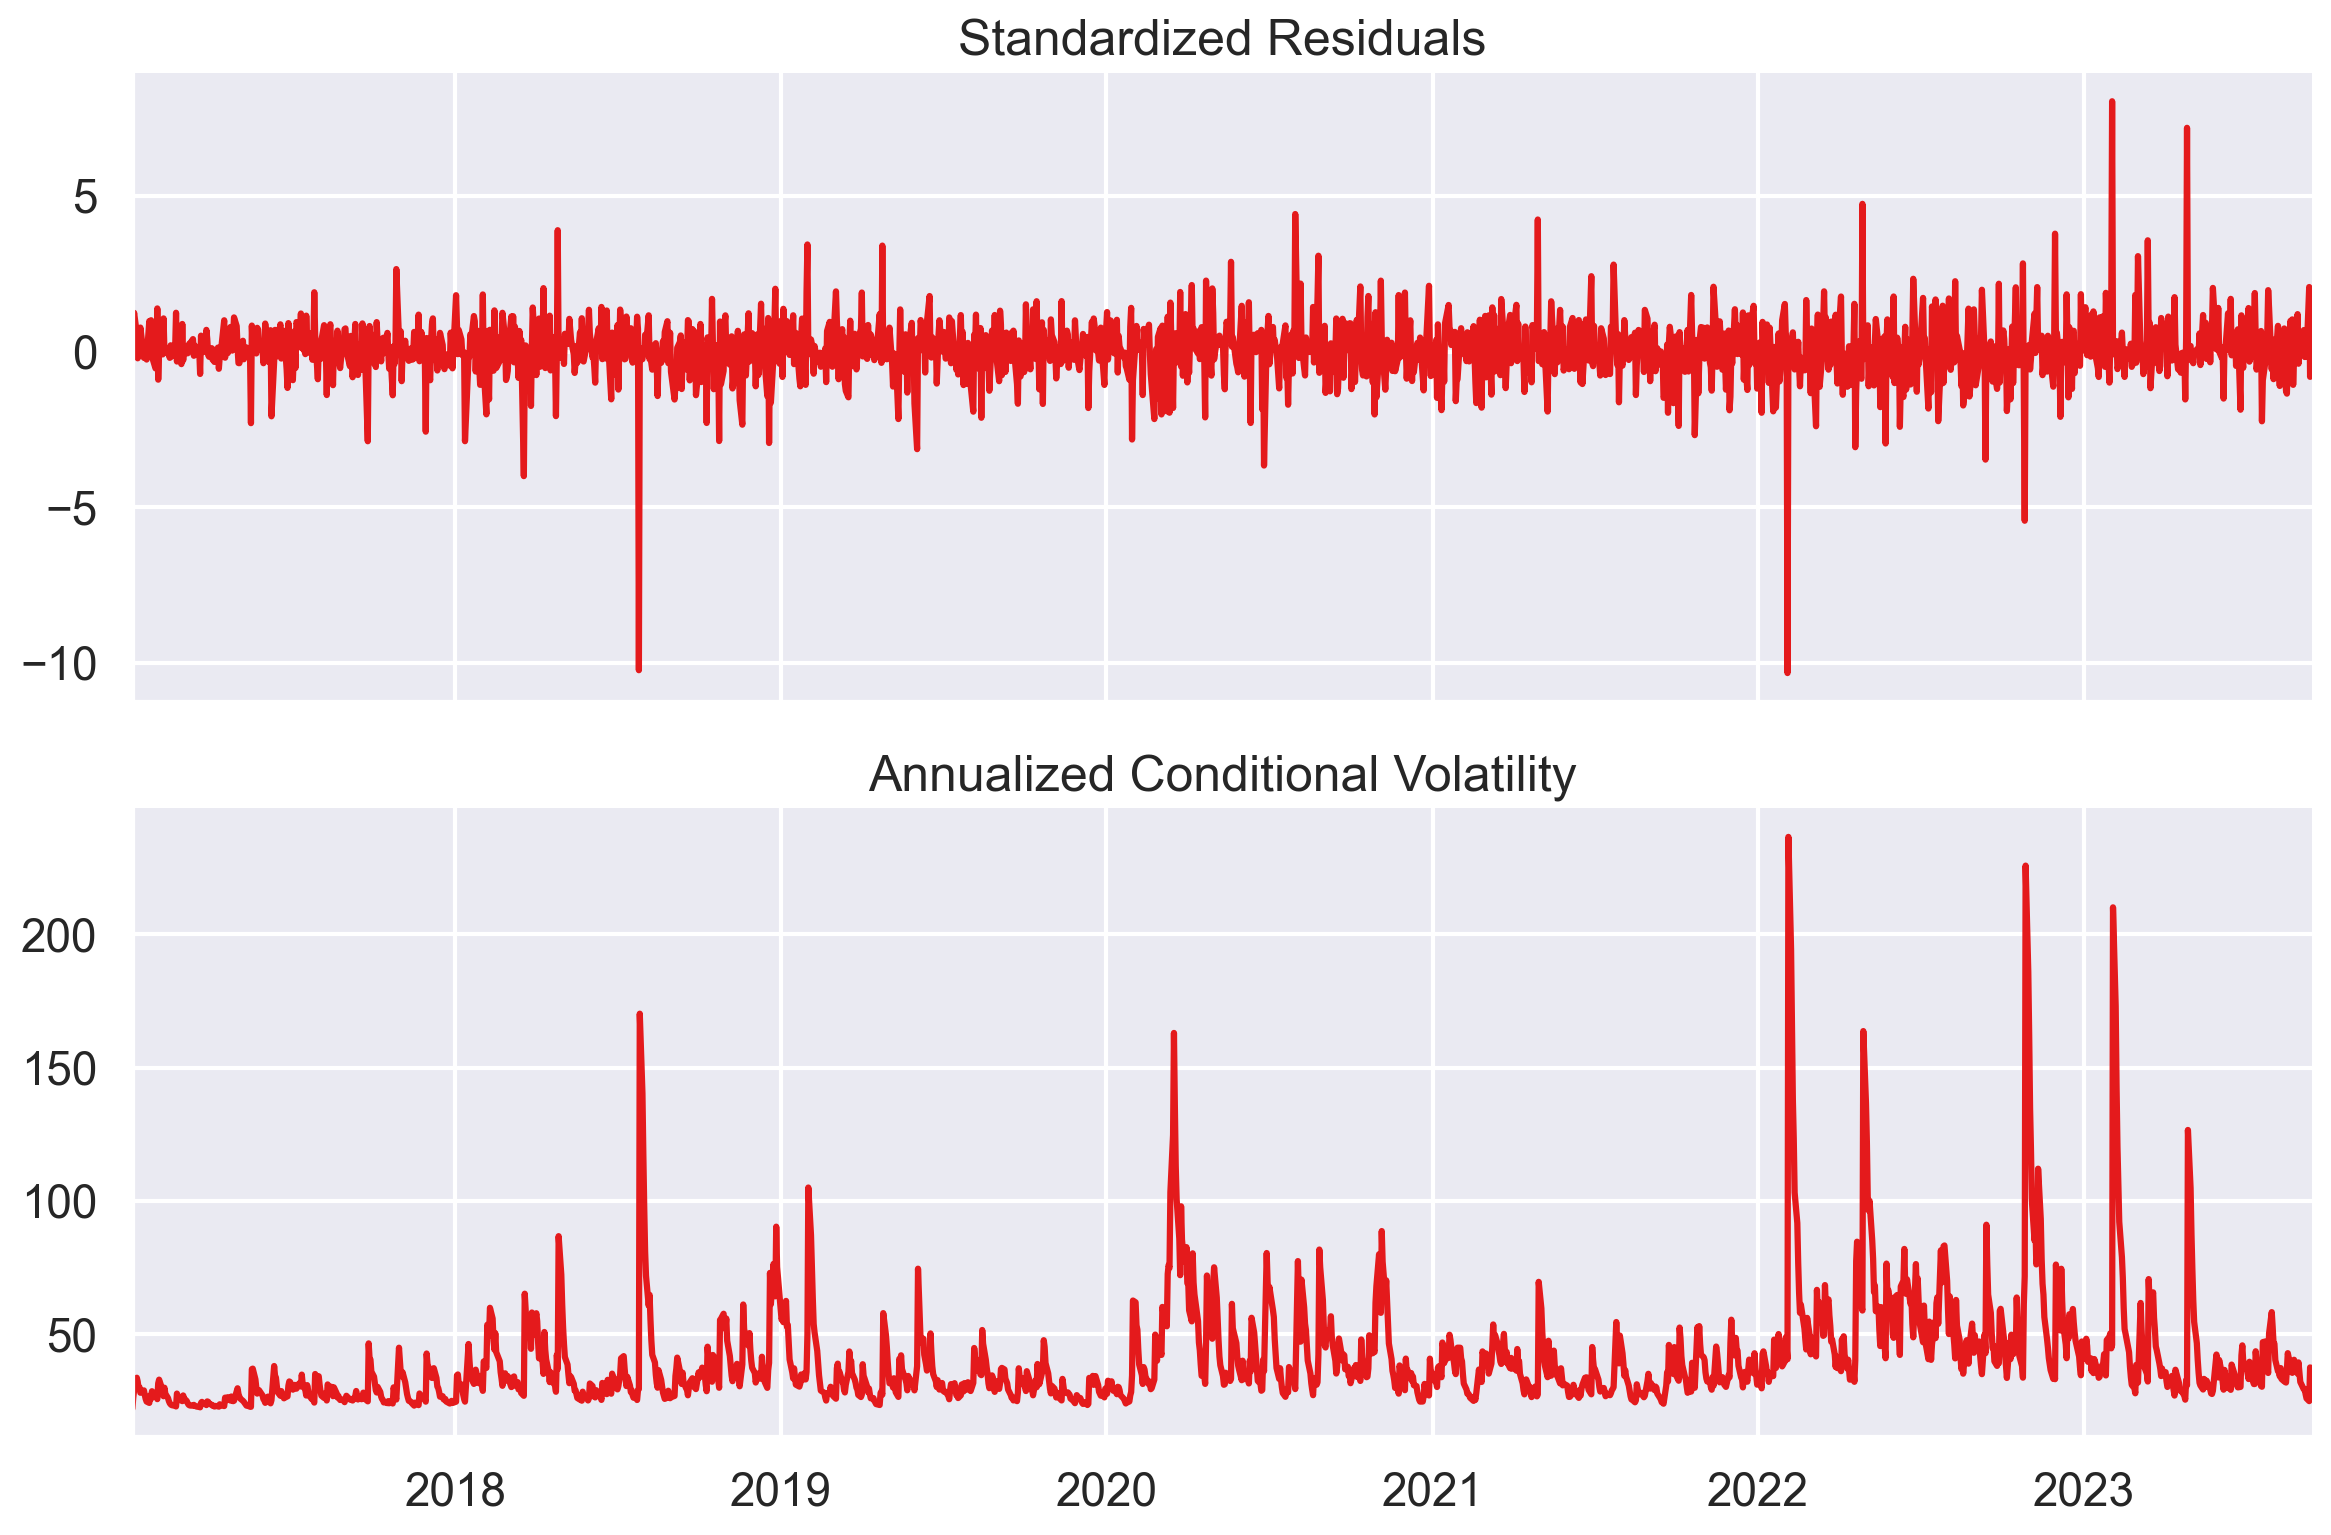

In [14]:
# 3. Plot the residuals and the conditional volatility:
fitted_model.plot(annualize="D")

sns.despine()
plt.tight_layout()

## Forecasting volatility using GARCH models

In [15]:
# 1. Import the libraries:
import pandas as pd
import yfinance as yf
from datetime import datetime
from arch import arch_model

In [16]:
# 2. Download data from Yahoo Finance and calculate simple returns:
df = yf.download("AAPL",
                 start="2017-01-01",
                 end="2023-09-15")

returns = 100 * df["Adj Close"].pct_change().dropna()
returns.name = "asset_returns"

[*********************100%%**********************]  1 of 1 completed


In [17]:
# 3. Specify the GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", dist="t",
                   p=1, q=1)

In [18]:
# 4. Define the split date and fit the model:
SPLIT_DATE = datetime(2021, 1, 1)
fitted_model = model.fit(last_obs=SPLIT_DATE, disp="off")

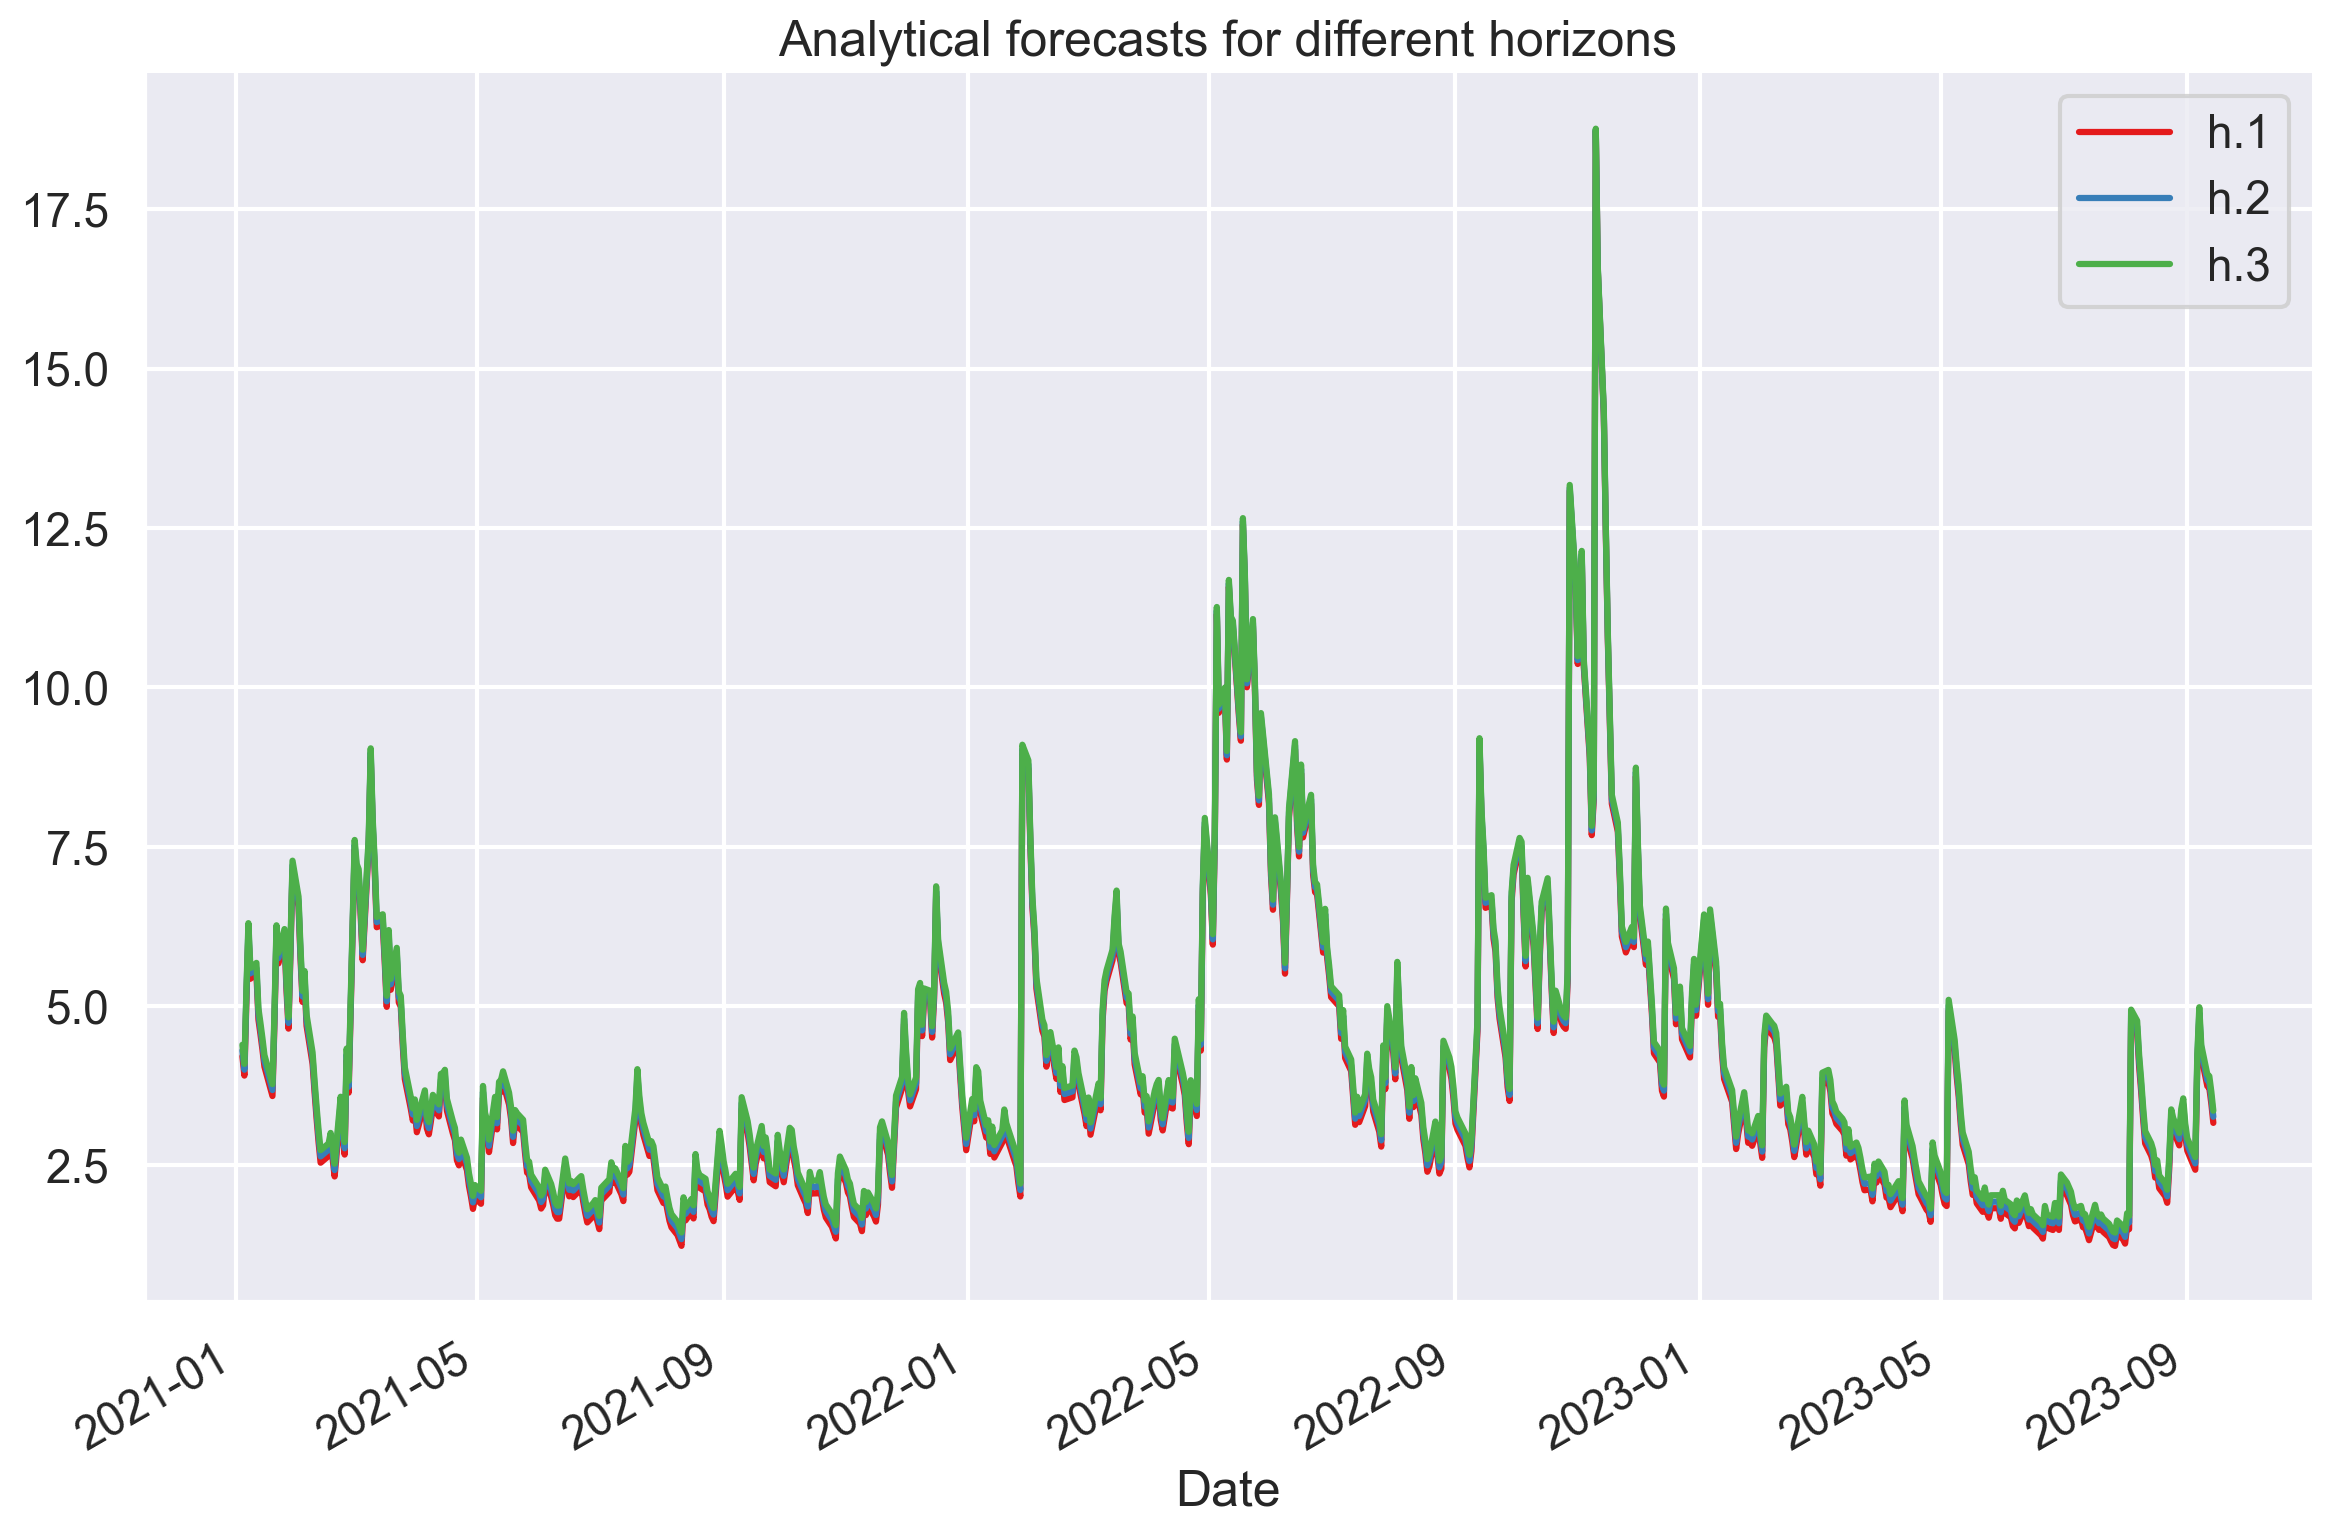

In [19]:
# 5. Create and inspect the analytical forecasts:
forecasts_analytical = fitted_model.forecast(horizon=3, 
                                             start=SPLIT_DATE,
                                             reindex=False)
forecasts_analytical.variance.plot(
    title="Analytical forecasts for different horizons"
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_4", dpi=200)

In [20]:
forecasts_analytical.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,4.211477,4.301943,4.391961
2021-01-05,3.908019,3.999987,4.091500
2021-01-06,5.089935,5.176053,5.261745
2021-01-07,6.138404,6.219333,6.299861
2021-01-08,5.427407,5.511855,5.595885
...,...,...,...
2023-09-08,4.205843,4.296337,4.386383
2023-09-11,3.743184,3.835968,3.928293
2023-09-12,3.713727,3.806657,3.899127


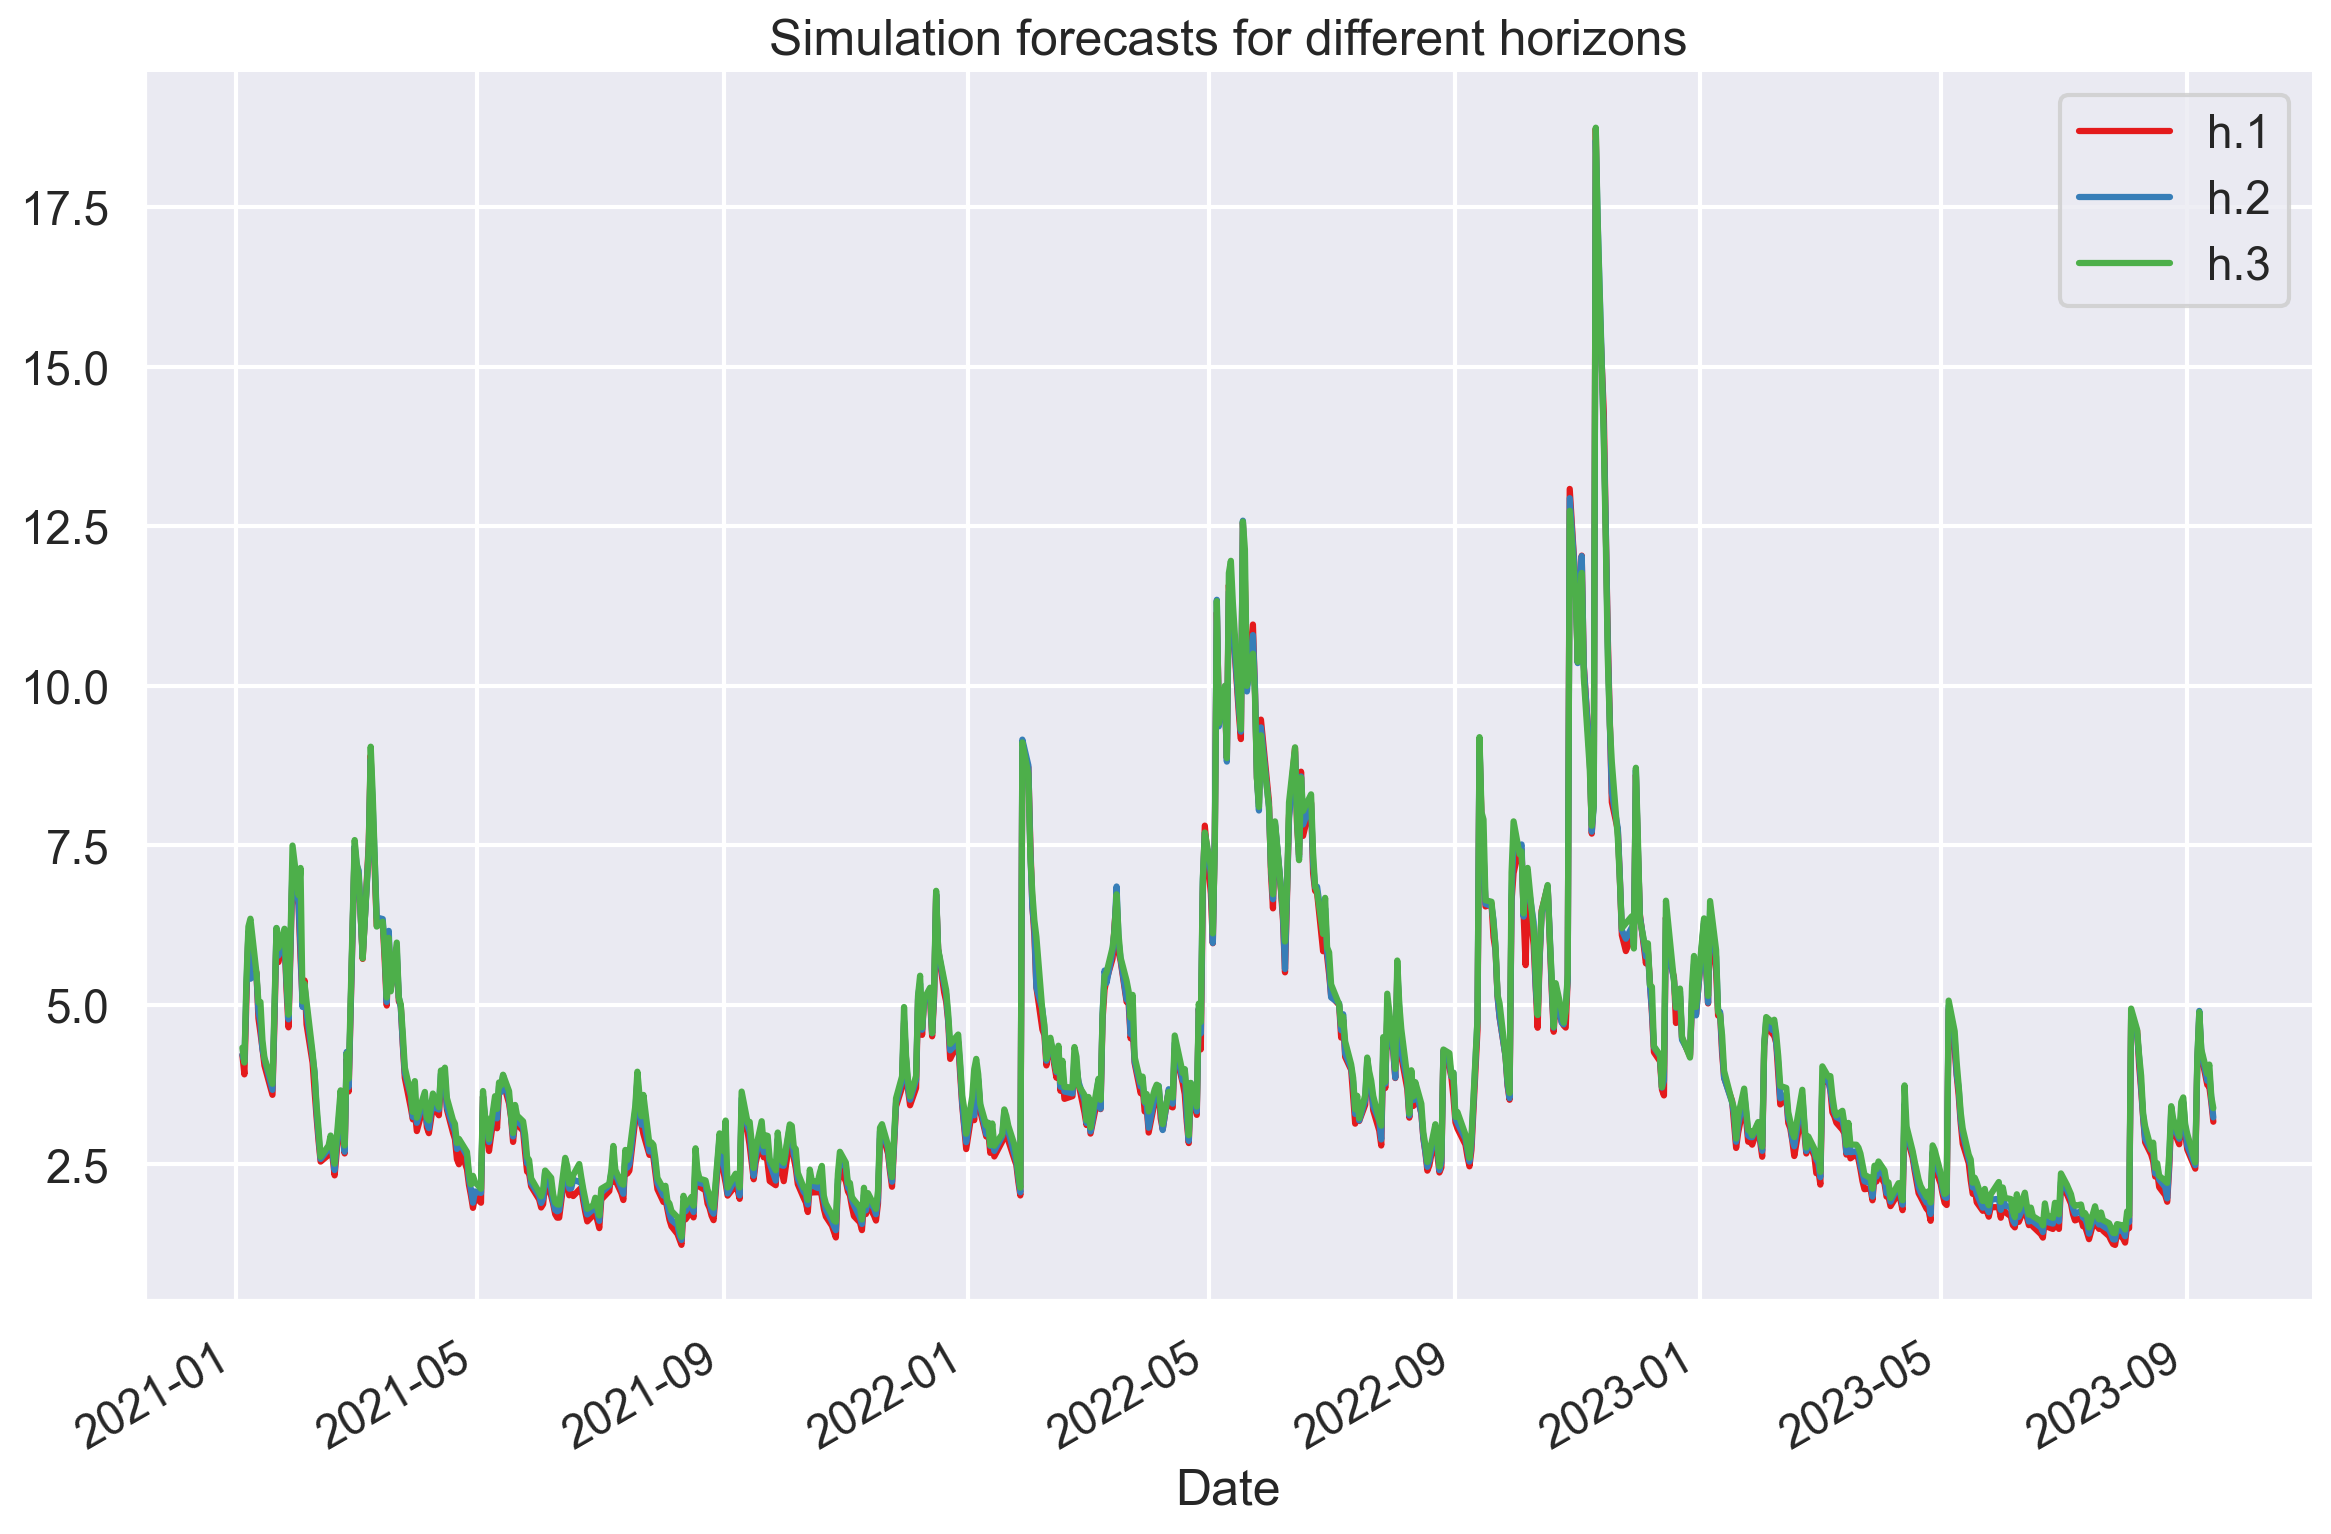

In [21]:
# 6. Create and inspect the simulation forecasts:
forecasts_simulation = fitted_model.forecast(horizon=3, 
                                             start=SPLIT_DATE,
                                             method="simulation",
                                             reindex=False)
forecasts_simulation.variance.plot(
    title="Simulation forecasts for different horizons"
)

sns.despine()
plt.tight_layout()

In [22]:
forecasts_simulation.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,4.211477,4.215577,4.326533
2021-01-05,3.908019,4.103788,4.093895
2021-01-06,5.089935,5.240677,5.380735
2021-01-07,6.138404,6.130236,6.224046
2021-01-08,5.427407,5.406718,6.347793
...,...,...,...
2023-09-08,4.205843,4.273585,4.301476
2023-09-11,3.743184,3.807250,3.915844
2023-09-12,3.713727,3.937532,4.061707


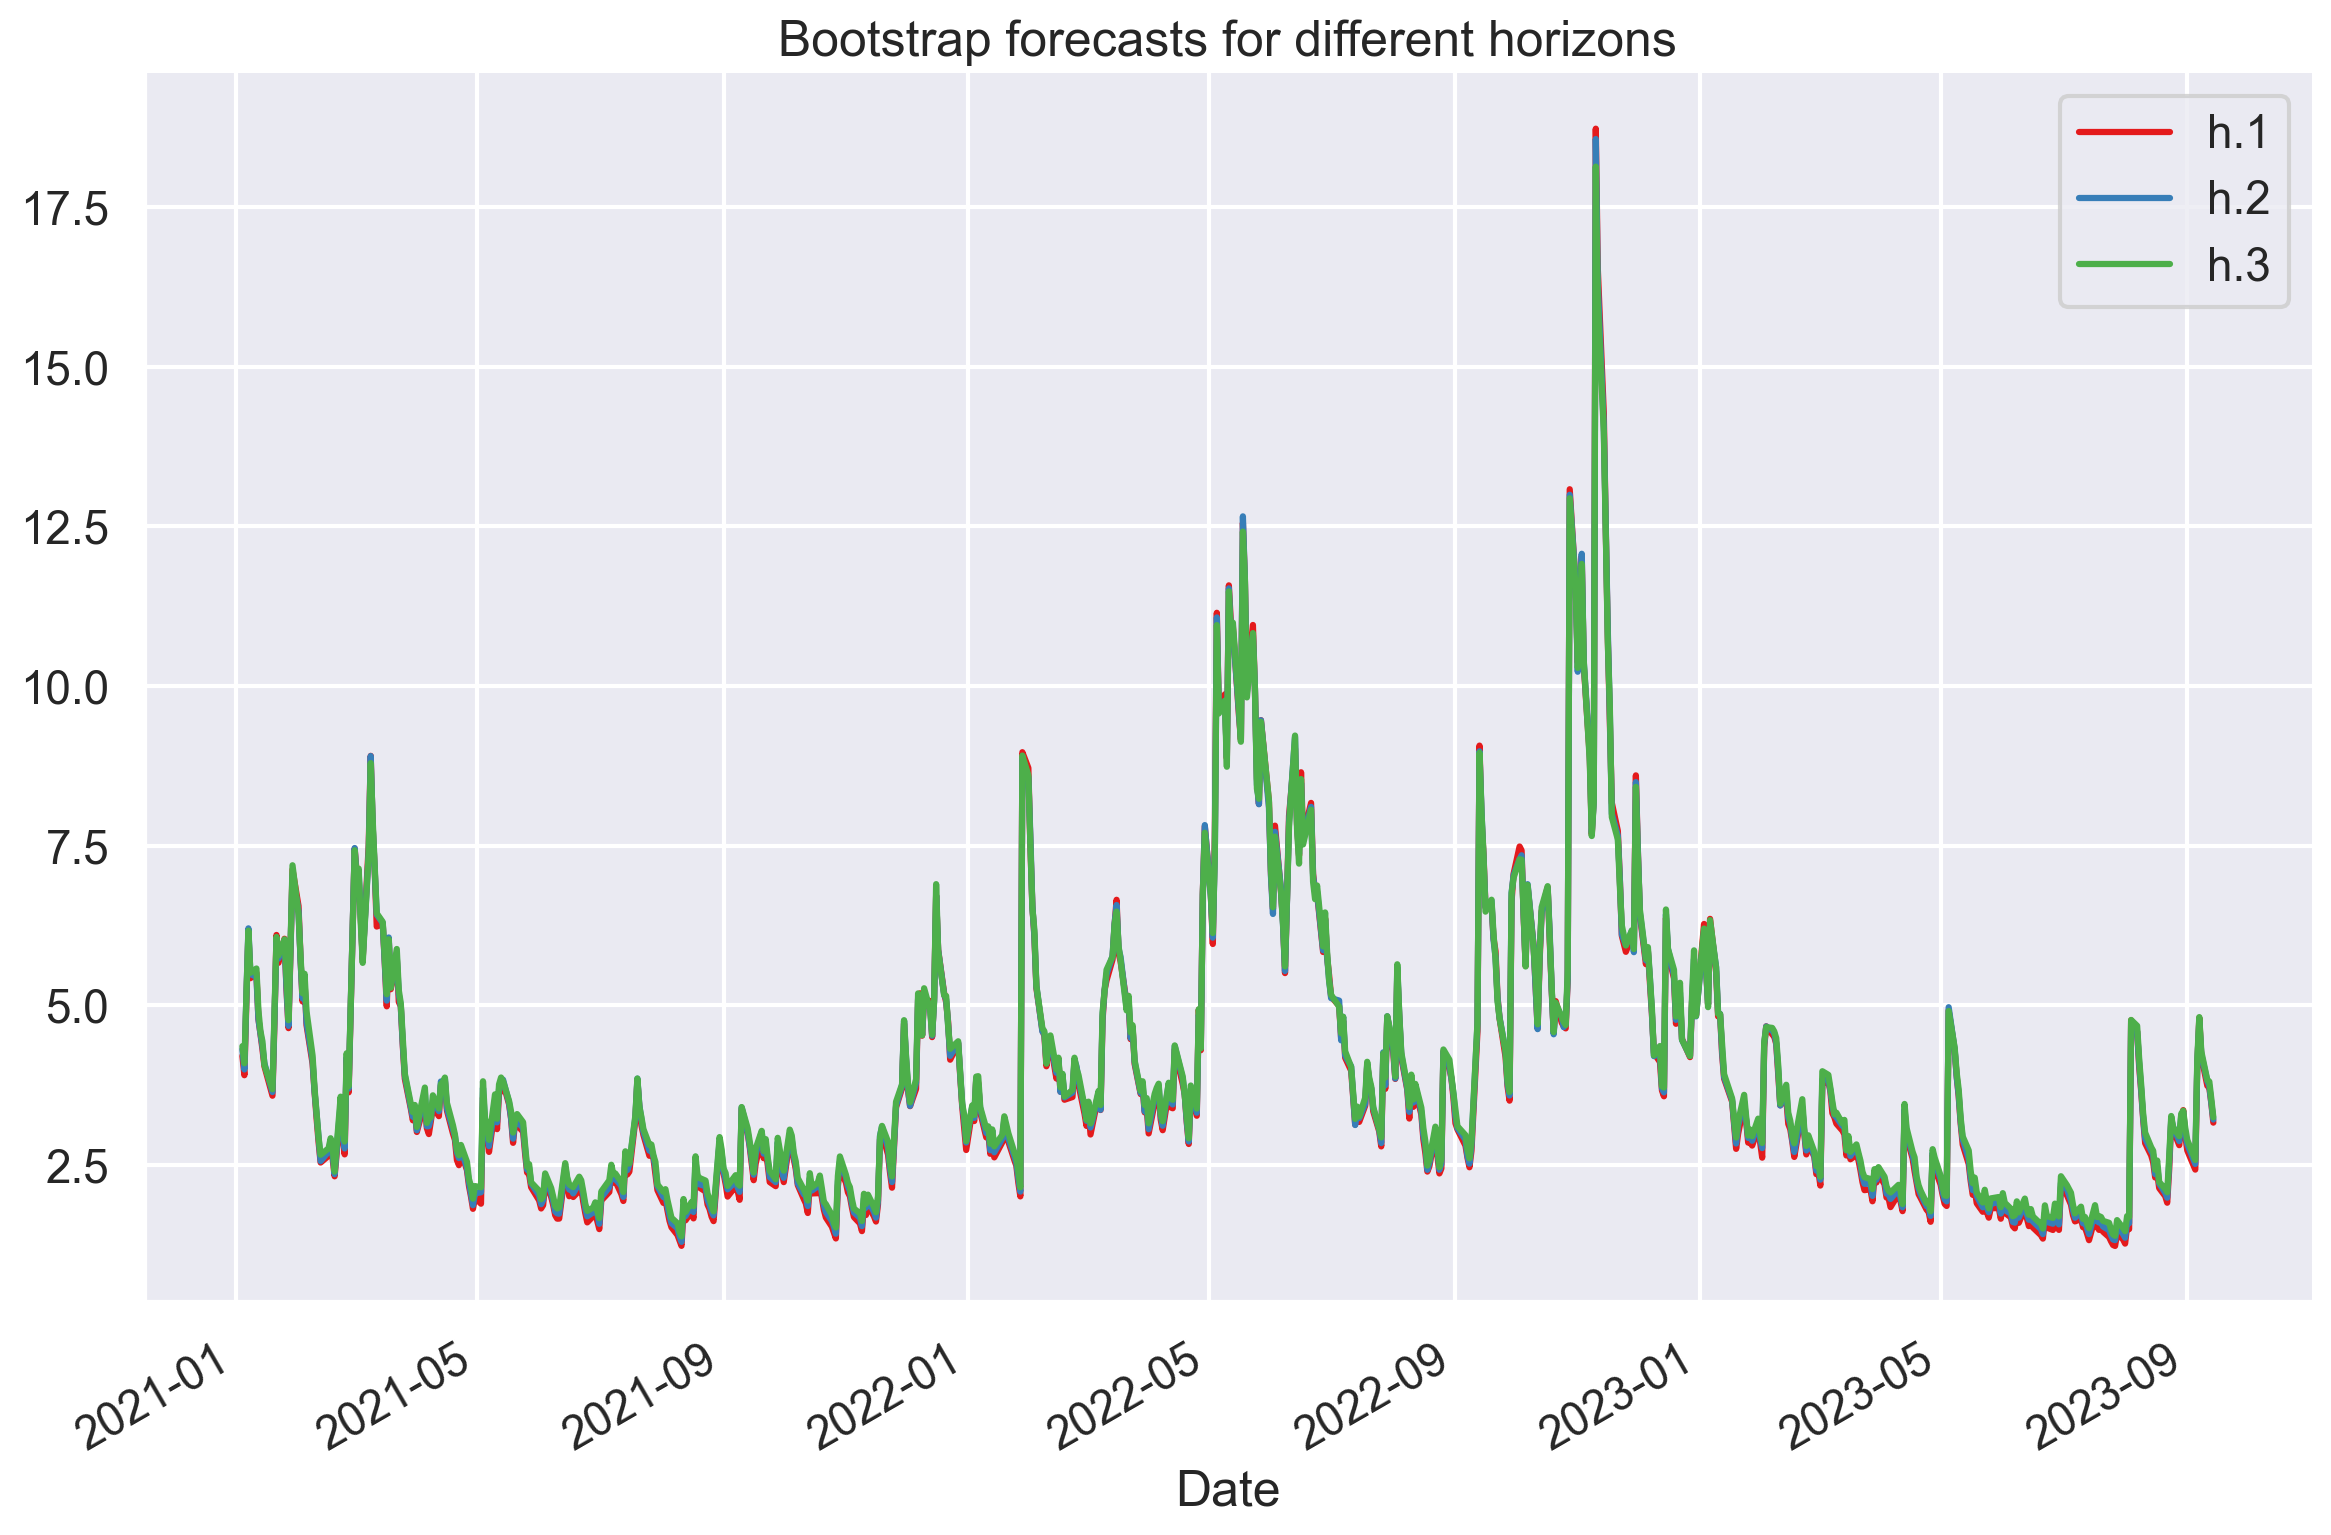

In [23]:
# 7. Create and inspect the bootstrap forecasts:
forecasts_bootstrap = fitted_model.forecast(horizon=3, 
                                            start=SPLIT_DATE,
                                            method="bootstrap",
                                            reindex=False)
forecasts_bootstrap.variance.plot(
    title="Bootstrap forecasts for different horizons"
)

sns.despine()
plt.tight_layout()

In [24]:
forecasts_bootstrap.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,4.211477,4.315072,4.362520
2021-01-05,3.908019,3.998184,4.094601
2021-01-06,5.089935,5.163123,5.168596
2021-01-07,6.138404,6.207688,6.172231
2021-01-08,5.427407,5.492578,5.511519
...,...,...,...
2023-09-08,4.205843,4.236414,4.281087
2023-09-11,3.743184,3.817195,3.831408
2023-09-12,3.713727,3.743056,3.809156


## Multivariate volatility forecasting with the CCC-GARCH model

In [25]:
# Import the libraries
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model

In [26]:
# 2. Specify the risky asset and the time horizon:
RISKY_ASSETS = ["AMZN", "TSLA", "AAPL"]
START_DATE = "2017-01-01"
END_DATE = "2023-09-15"

In [27]:
# 3. Download data from Yahoo Finance:
df = yf.download(RISKY_ASSETS,
                 start=START_DATE,
                 end=END_DATE)

print(f"Downloaded {df.shape[0]} rows of data.")

[*********************100%%**********************]  3 of 3 completed
Downloaded 1686 rows of data.


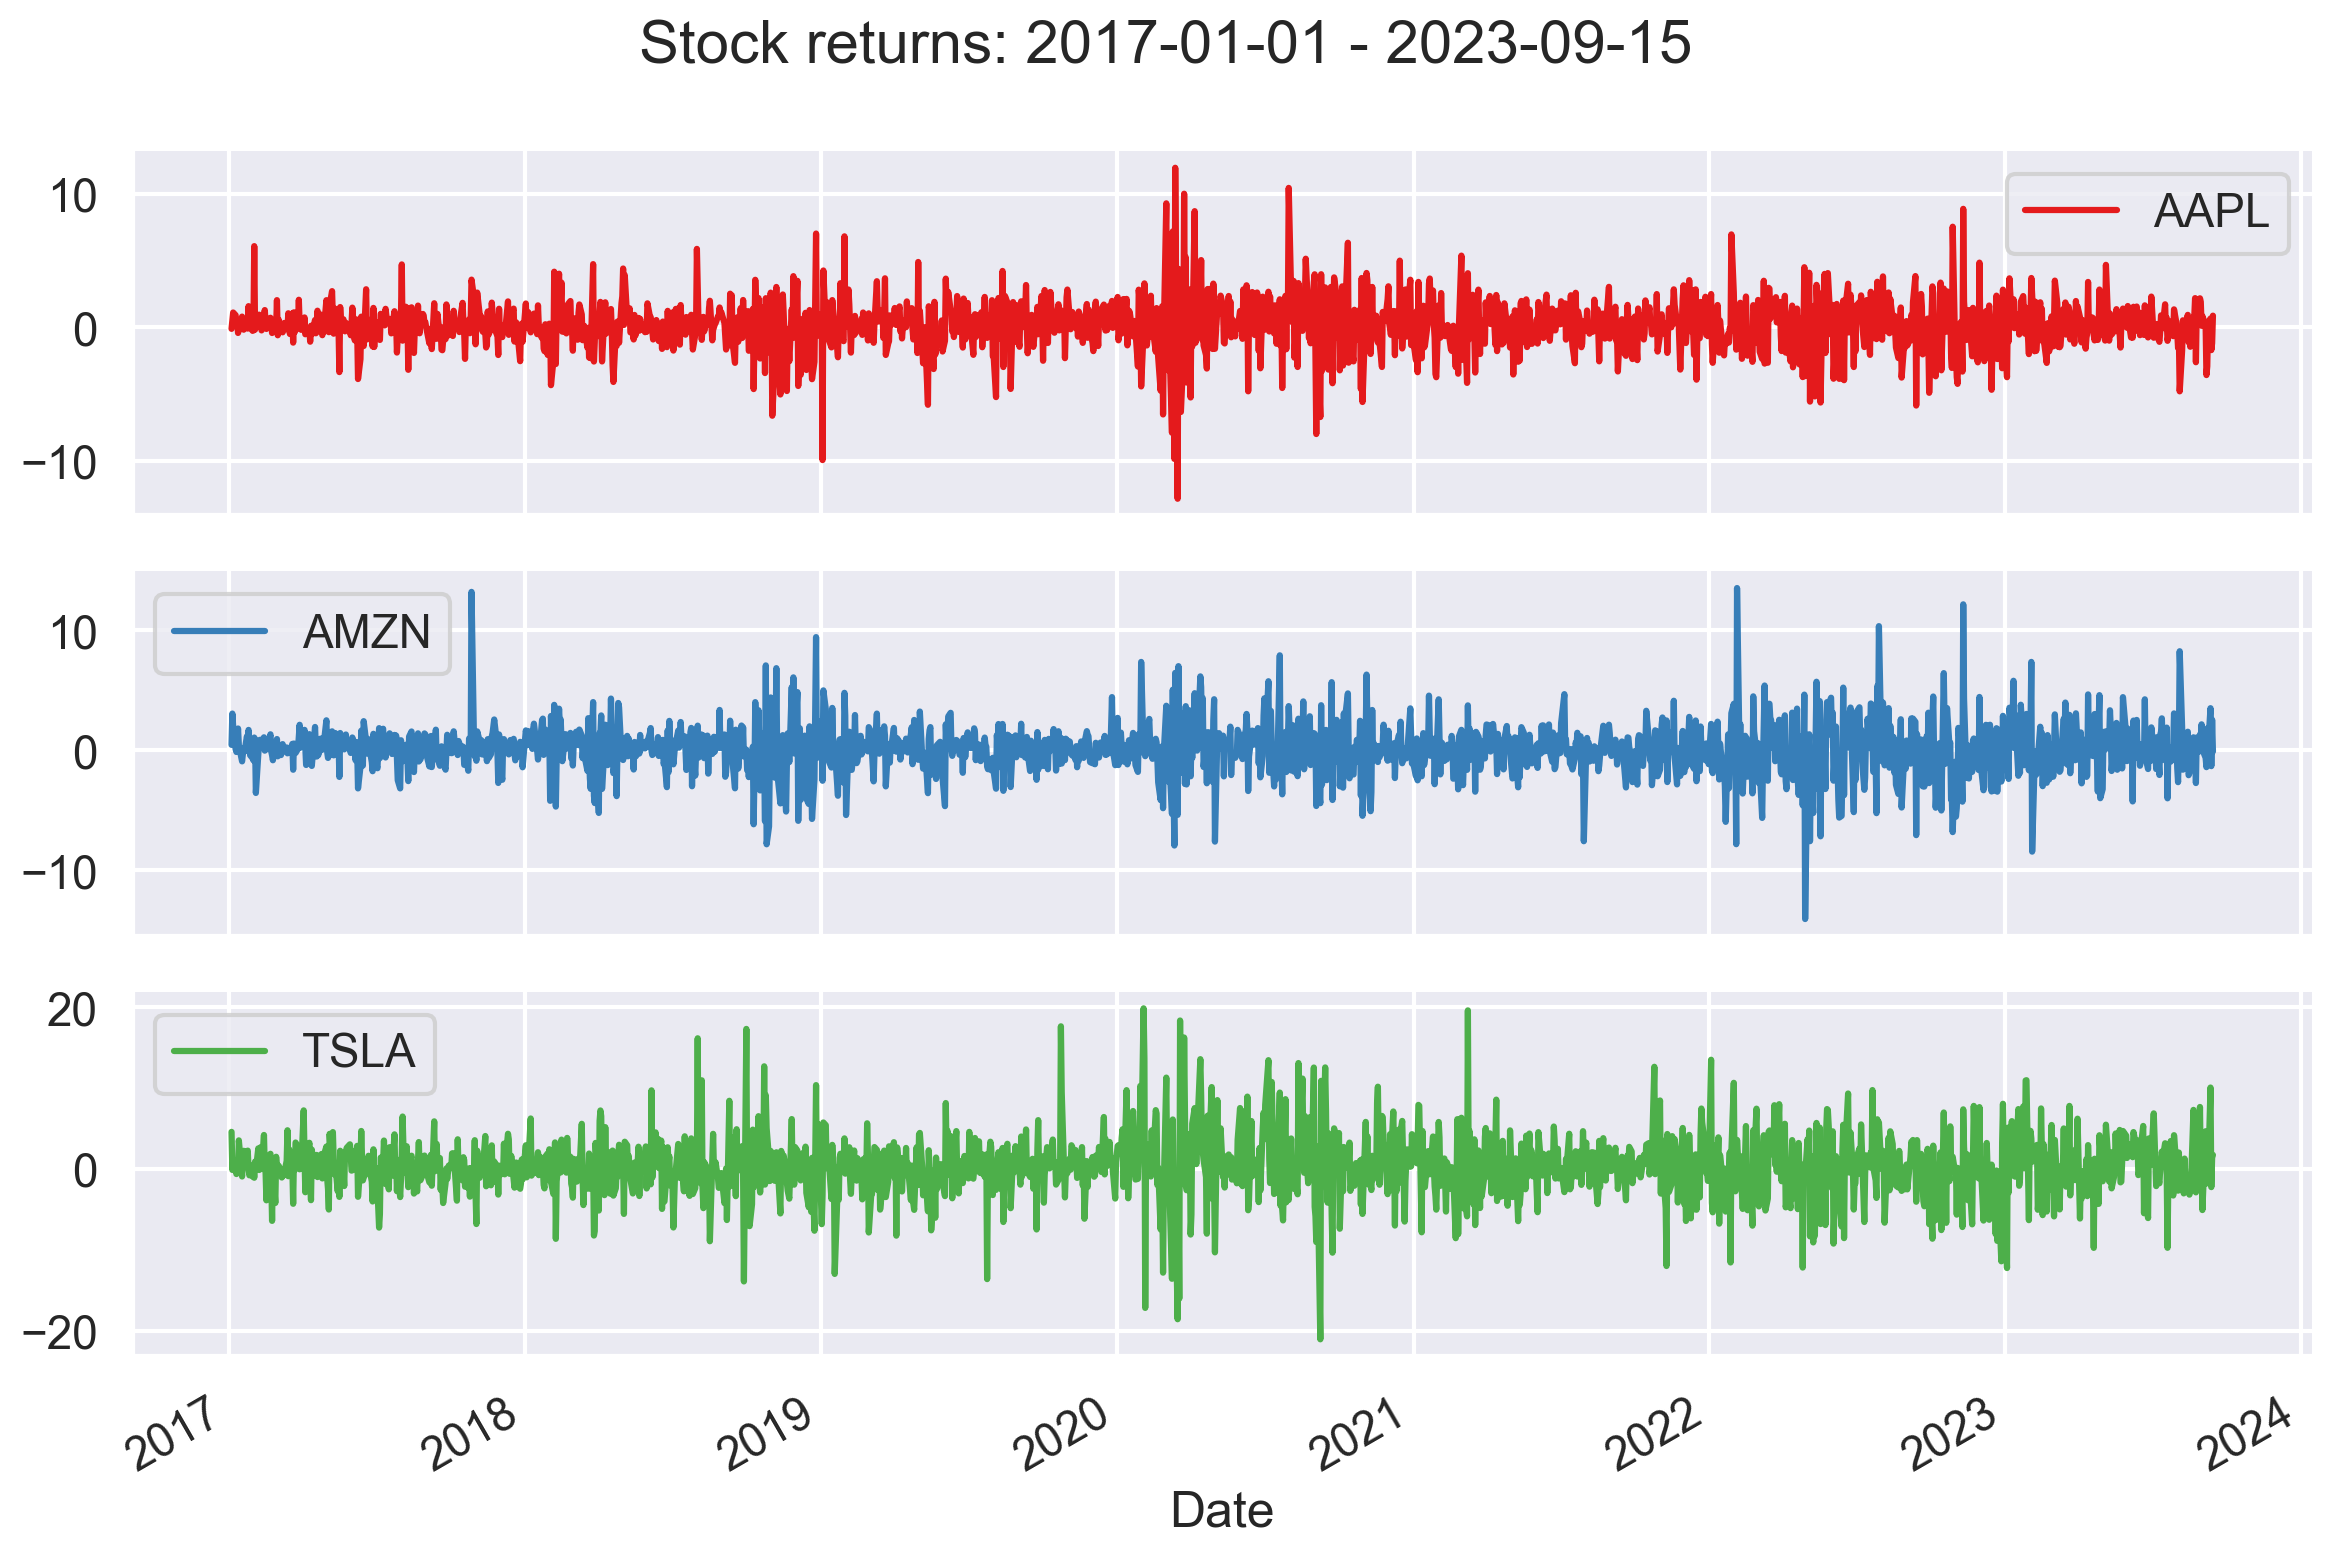

In [28]:
# 4. Calculate daily returns:
returns = 100 * df["Adj Close"].pct_change().dropna()
returns.plot(subplots=True, 
             title=f"Stock returns: {START_DATE} - {END_DATE}")

sns.despine()
plt.tight_layout()

In [29]:
# 5. Define lists for storing objects:
coeffs = []
cond_vol = []
std_resids = []
models = []

In [30]:
# 6. Estimate the univariate GARCH models:
for asset in returns.columns:
    # specify and fit the model
    model = arch_model(returns[asset], mean="Constant", 
                       vol="GARCH", p=1, q=1)
    model = model.fit(update_freq=0, disp="off");
    
    # store results in the lists 
    coeffs.append(model.params)
    cond_vol.append(model.conditional_volatility)
    std_resids.append(model.std_resid)
    models.append(model)

In [31]:
# 7. Store the results in DataFrames:
coeffs_df = pd.DataFrame(coeffs, index=returns.columns)
cond_vol_df = (
    pd.DataFrame(cond_vol)
    .transpose()
    .set_axis(returns.columns,
              axis="columns")
)
std_resids_df = (
    pd.DataFrame(std_resids)
    .transpose()
    .set_axis(returns.columns, 
              axis="columns")
)

In [32]:
coeffs_df

,mu,omega,alpha[1],beta[1]
AAPL,0.218136,0.141651,0.113960,0.847826
AMZN,0.192797,0.244515,0.158420,0.796339
TSLA,0.234297,0.250312,0.045385,0.938014


In [33]:
# 8. Calculate the constant conditional correlation matrix (R):
R = (
    std_resids_df
    .transpose()
    .dot(std_resids_df)
    .div(len(std_resids_df))
)

In [34]:
# 9. Calculate the 1-step ahead forecast of the conditional covariance matrix :
# define objects
diag = []
D = np.zeros((len(RISKY_ASSETS), len(RISKY_ASSETS)))

# populate the list with conditional variances
for model in models:
    diag.append(model.forecast(horizon=1).variance.iloc[-1, 0])
# take the square root to obtain volatility from variance
diag = np.sqrt(diag)
# fill the diagonal of D with values from diag
np.fill_diagonal(D, diag)

# calculate the conditional covariance matrix
H = np.matmul(np.matmul(D, R.values), D)

In [35]:
H

array([[ 2.95513803,  1.83958889,  2.49620122],
       [ 1.83958889,  3.5093132 ,  2.60799364],
       [ 2.49620122,  2.60799364, 13.84318077]])